In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv 
import os
import glob
from PIL import Image

In [2]:
all_features = []

In [7]:
import pandas as pd

def combine_vectors_from_csv(files):
    combined_data = {}  # Dictionary to store combined vectors

    for idx, file in enumerate(files):
        df = pd.read_csv(file)
        for index, row in df.iterrows():
            image_name = row['ImageName']
            vector = row['Vector']

            if image_name in combined_data:
                # If the image name already exists, add the vector components to the respective VectorX columns
                combined_data[image_name][f'Vector{idx + 1}'] = eval(vector)
            else:
                # If the image name doesn't exist in the dictionary, add it with the current vector
                combined_data[image_name] = {
                    f'Vector{idx + 1}': eval(vector)
                }

    # Create a new DataFrame with the combined vectors
    combined_df = pd.DataFrame.from_dict(combined_data, orient='index')
    combined_df = combined_df.reset_index()
    combined_df.columns = ['ImageName'] + [f'Vector{i}' for i in range(1, len(files) + 1)]

    return combined_df


In [28]:
# List of CSV files to read
csv_files = ['colored_hist_features.csv', 'lbp_fetures.csv',"HOG_features.csv", 'resnet_features.csv']



In [29]:
# Call the function to combine vectors from the CSV files
combined_df = combine_vectors_from_csv(csv_files)

# Save the combined data to a new CSV file
combined_df.to_csv('combined_vectors.csv', index=False)

In [49]:
import pandas as pd
from sklearn.decomposition import PCA
import ast
import numpy as np

def parse_vector(vector_str):
    # Parse a string like '(0.0, 0.0, 0.0, ...)' into a list of floats
    vector_list = ast.literal_eval(vector_str)
    return vector_list

def pad_vector(vector, target_length):
    # Convert the tuple to a list and then pad or truncate it to the target length
    vector = list(vector)
    return vector + [0.0] * (target_length - len(vector))

def apply_pca_and_save(input_file, output_file, num_components=1):
    # Read the input CSV file
    data = pd.read_csv(input_file)

    # Extract the image names and vectors
    image_names = data['ImageName']
    vectors = data.drop(columns=['ImageName'])

    # Parse and convert the string representations of vectors to lists of floats
    vectors = vectors.applymap(parse_vector)

    # Find the maximum vector length in the dataset
    max_vector_length = max(vectors.applymap(len).max())

    reduced_vectors = []
    pca = PCA(n_components=num_components)

    for _, row in vectors.iterrows():
        # Pad or truncate vectors to the maximum length
        padded_row = [pad_vector(vector, max_vector_length) for vector in row]

        # Apply PCA for dimensionality reduction
        reduced_row = pca.fit_transform(padded_row)
        reduced_vectors.append(reduced_row)

    # Create a new DataFrame with reduced vectors and image names
    reduced_data = pd.DataFrame({'ImageName': image_names, 'ReducedVec': [vec.tolist() for vec in reduced_vectors]})

    # Save the reduced data to a new CSV file
    reduced_data.to_csv(output_file, index=False)

# Example usage
input_file = 'combined_vectors.csv'
output_file = 'PCA_Features.csv'
num_components = 1  # Number of components for PCA
apply_pca_and_save(input_file, output_file, num_components)


C:\Users\yamrs\AppData\Local\Temp\ipykernel_23096\1518895805.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vectors = vectors.applymap(parse_vector)
C:\Users\yamrs\AppData\Local\Temp\ipykernel_23096\1518895805.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_vector_length = max(vectors.applymap(len).max())


In [50]:
def euclidean(a, b):
    return np.linalg.norm(a - b)
def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [62]:
import csv
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine

def calculate_distances(image_name1, image_name2, csv_file_path="PCA_Features.csv"):
    vector1 = None
    vector2 = None

    # Read the CSV file to get the vectors for the given image names.
    with open(csv_file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)  # Skip the header row
        for row in csv_reader:
            if row[0] == image_name1:
                values = [float(value.strip("[] ")) for value in row[1].split(',')]
                vector1 = np.array(values)
            if row[0] == image_name2:
                values = [float(value.strip("[] ")) for value in row[1].split(',')]
                vector2 = np.array(values)

    if vector1 is None or vector2 is None:
        print("One or both of the images were not found in the CSV file.")
        return

    # Calculate Euclidean distance and cosine similarity between the vectors.
    euclidean_distance = euclidean(vector1, vector2)
    cosine_similarity = cosine(vector1, vector2)

    return euclidean_distance, cosine_similarity

val = calculate_distances("banded_0002.jpg", "banded_0004.jpg")

print("Euclidean Distance:", val[0])
print("Cosine Similarity:", val[1])


Euclidean Distance: 143283.41305716493
Cosine Similarity: 7.494782572337044e-12


In [83]:
import csv
import numpy as np
from PIL import Image
from scipy.spatial.distance import cosine, euclidean

def search(query_image_name, csv_file_path, top_k=5):
    # Read the CSV file to get image vectors.
    image_data_list = []
    with open(csv_file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)  # Skip the header row
        for row in csv_reader:
            image_name = row[0]
            vector = np.array(list(map(float, row[1].split(','))))
            image_data_list.append((image_name, vector))

    # Find the query vector based on the provided query_image_name.
    query_vector = None
    for image_name, vector in image_data_list:
        if image_name == query_image_name:
            query_vector = vector
            break

    if query_vector is None:
        raise ValueError(f"Query image '{query_image_name}' not found in the CSV file.")

    # Calculate cosine and Euclidean distances between the query vector and all other vectors.
    cosine_similarities = []
    euclidean_distances = []
    for image_name, vector in image_data_list:
        cosine_similarity = cosine(query_vector, vector)
        euclidean_distance = euclidean(query_vector, vector)
        cosine_similarities.append((image_name, cosine_similarity))
        euclidean_distances.append((image_name, euclidean_distance))

    # Sort the images by similarity/distance in descending order.
    top_cosine_similar_images = sorted(cosine_similarities, key=lambda x: x[1], reverse=True)[:top_k]
    top_euclidean_similar_images = sorted(euclidean_distances, key=lambda x: x[1])[:top_k]

    return top_cosine_similar_images, top_euclidean_similar_images, query_vector


In [85]:
query_image_path = "porous_0176.jpg"
cosine_results, euclidean_results,query_vector  = search(query_image_path, 'colored_hist_features.csv', top_k=5)


print("\nTop 5 Cosine Similar Images:")
for i, (image_name, similarity) in enumerate(cosine_results, 1):
    print(f"Top {i}: {image_name} (Similarity: {similarity:.4f})")

print("\nTop 5 Euclidean Distance Images:")
for i, (image_name, distance) in enumerate(euclidean_results, 1):
    print(f"Top {i}: {image_name} (Euclidean Distance: {distance:.4f})")


Top 5 Cosine Similar Images:
Top 1: grid_0061.jpg (Similarity: 0.9999)
Top 2: grid_0060.jpg (Similarity: 0.9999)
Top 3: grid_0047.jpg (Similarity: 0.9999)
Top 4: dotted_0129.jpg (Similarity: 0.9995)
Top 5: grid_0056.jpg (Similarity: 0.9995)

Top 5 Euclidean Distance Images:
Top 1: porous_0176.jpg (Euclidean Distance: 0.0000)
Top 2: crosshatched_0137.jpg (Euclidean Distance: 20353.4780)
Top 3: veined_0001.jpg (Euclidean Distance: 21072.8963)
Top 4: pitted_0065.jpg (Euclidean Distance: 21601.9438)
Top 5: matted_0151.jpg (Euclidean Distance: 21665.9753)


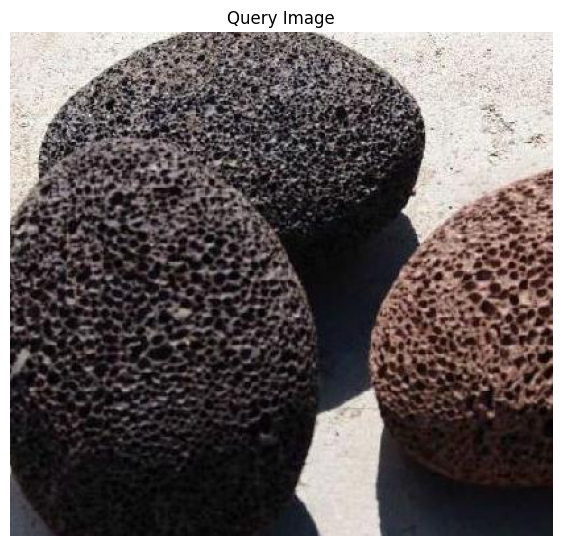

In [88]:
import matplotlib.pyplot as plt
from PIL import Image

query_image_path = "dtd-r1.0.1/dtd/images/porous/porous_0175.jpg"

# Load the query image using PIL.
query_image = Image.open(query_image_path)
query_image_array = np.array(query_image)

# Visualize the query image
plt.figure(figsize=(7, 7))
plt.imshow(query_image_array)
plt.title('Query Image')
plt.axis('off')
plt.show()


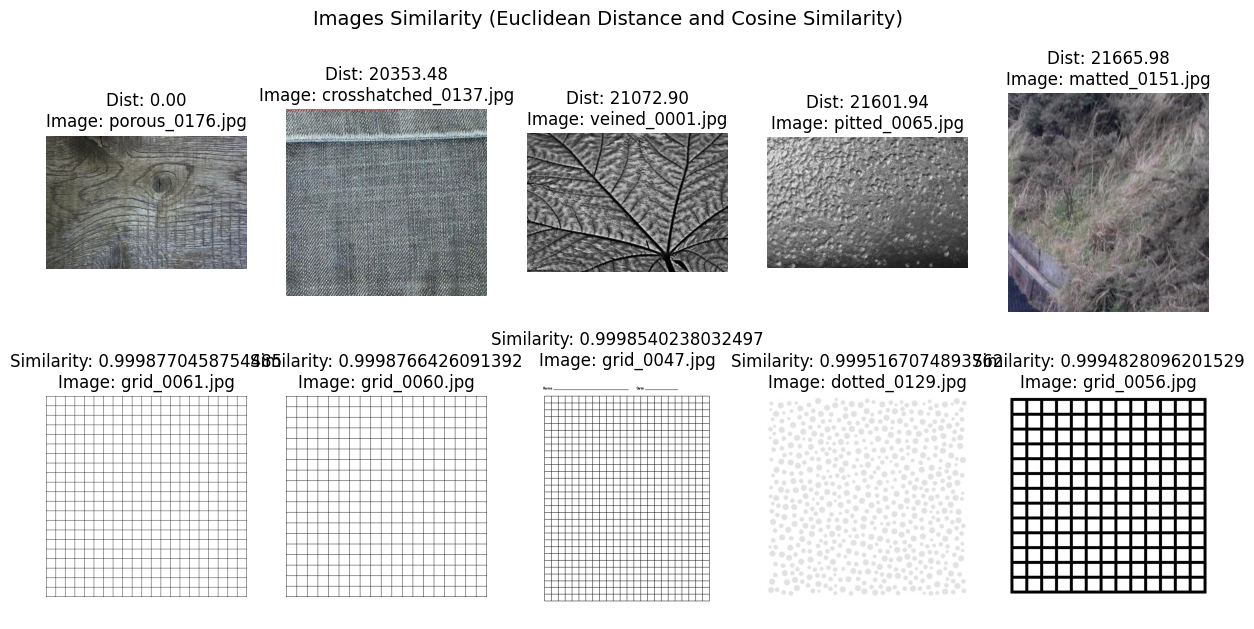

In [89]:
import re

from PIL import Image

top_k = 5

# Regular expression pattern to remove numbers, "jpg", and underscores
pattern = r'\d+|\.jpg|_'

fig, axes = plt.subplots(2, top_k, figsize=(15, 7))
fig.suptitle('Images Similarity (Euclidean Distance and Cosine Similarity)', fontsize=14)

# Plot the closest images based on Euclidean distance.
for i, (image_name, distance) in enumerate(euclidean_results[:top_k]):
    # Clean the image_name to remove numbers, "jpg," and underscores
    cleaned_file_path = re.sub(pattern, '', image_name)

    # Construct the full path to the image
    image_path = f'dtd-r1.0.1/dtd/images/{cleaned_file_path}/{image_name}'

    # Open and plot the image
    image = Image.open(image_path)
    axes[0, i].imshow(image)
    axes[0, i].set_title(f'Dist: {distance:.2f}\nImage: {image_name}')
    axes[0, i].axis('off')

# Plot the closest images based on Cosine similarity.
for i, (image_name, similarity) in enumerate(cosine_results[:top_k]):
    # Clean the image_name to remove numbers, "jpg," and underscores
    cleaned_file_path = re.sub(pattern, '', image_name)

    # Construct the full path to the image
    image_path = f'dtd-r1.0.1/dtd/images/{cleaned_file_path}/{image_name}'

    # Open and plot the image
    image = Image.open(image_path)
    axes[1, i].imshow(image)
    axes[1, i].set_title(f'Similarity: {similarity:}\nImage: {image_name}')
    axes[1, i].axis('off')

plt.show()


In [1]:
import csv
import time
import re

import csv
import time
import re

pattern = r'\d+|\.jpg|_'

def calculate_precision_at_k(true_image, top_k_results):
    pattern = r'\d+|\.jpg|_'
    total = 0

    for result in top_k_results:
        filename, _ = result
        filename = re.sub(pattern, '', filename)
        if filename == true_image:
            print("true")
            # print(true_image)
            # print(filename)
            total += 1
            
            
        else:
            print("false")
            # print(true_image)
            # print(filename)
        
        return total
    

def calculate_precision_at_1(true_image, top_k_results):
    pattern = r'\d+|\.jpg|_'

    if top_k_results:
        filename, _ = top_k_results[0]
        filename = re.sub(pattern, '', filename)
        if filename == true_image:
            return 1.0
        else:
            return 0.0



    

def calculate_average_precision_at_k(csv_file_path, top_k):
    with open(csv_file_path, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)  # Skip the header row
        total_precision_at_k = 0
        total_retrieval_time = 0
        total_precision_at_1 = 0
        total_images = 0
        top_k = 10

        for row in csv_reader:
            image_name, _ = row[0], row[1]
            cleaned_file_path = re.sub(pattern, '', image_name)
            print(image_name)
            image_path = f'dtd-r1.0.1/dtd/images/{cleaned_file_path}/{image_name}'
            query_image_path = image_path
            #print(query_image_path)
            start_time = time.time()
            top_cosine_similar_images, _, _ = search(query_image_path, csv_file_path, top_k)
            retrieval_time = time.time() - start_time
            precision_at_k = calculate_precision_at_k(cleaned_file_path, top_cosine_similar_images)
            precision_at_1 = calculate_precision_at_1(cleaned_file_path, top_cosine_similar_images)

            total_precision_at_k += precision_at_k
            total_retrieval_time += retrieval_time
            total_precision_at_1 += precision_at_1
            total_images += 1

    average_precision_at_k = total_precision_at_k / total_images
    average_retrieval_time = total_retrieval_time / total_images
    print("total_images: ", total_images)
    print("total_precision_at_k: ", total_precision_at_k)
    print("total_retrieval_time: ",total_retrieval_time)

    return average_precision_at_k, average_retrieval_time, total_precision_at_1

csv_file_path = 'PCA_Features.csv'
top_k = 10  # You can change this value as needed

average_precision_at_10, average_retrieval_time, total_precision_at_1 = calculate_average_precision_at_k(csv_file_path, top_k)

print(f'Average Precision at {top_k}: {average_precision_at_10}')
print(f'Average Retrieval Time: {average_retrieval_time} seconds')
print(f'Average Precision at 1: {total_precision_at_1}')


banded_0002.jpg


NameError: name 'search' is not defined